In [1]:
# Импорт библиотек
import os
import time

import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel("streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)
############################################################
# Теплосеть и перекидка температуры воздуха
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWINB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SWOUT", "T"] = SP.Tset(Tnv)[0]
water_streams.at["SWIN-TURB", "T"] = water_streams.at["SWINB", "T"]
water_streams.at["SP2-WOUT", "T"] = water_streams.at["SWOUT", "T"]
############################################################


# Основные эффективности оборудования
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99


# Параметры, отвечающие за процесс расчета
Calcmethod = "hybr"
Calctolerance = 10**-2
Maxiterations_KU_TU = 20
Maxiterations_cotel = 4
Maxiterations_turbine = 30

# Параметры режима работы ПГУ
# Расчет для минимума нагрузки
Сalculate_minimum = True
# Расчет для работы с теплофикацией
Teplo = int(True)
# Отбор пара высокго давления или доля или кг/с
steamVD_fraction_to_turbine = 1


# Состав газов в номинале в ГТУ
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = list(gas_streams0.loc["GTU-PEVD", "N2":"Ar"])
gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

#####################
######Максимов#######
fractionwaterMethane = (0.833372660622383, 0.166627339377617, 0, 0, 0)
waterMethanemix = "Water*METHANE"

waterMethane = prop.Materials_prop(
    waterMethanemix,
    fractionwaterMethane,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
Methane = prop.Materials_prop(
    "METHANE",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
gas_KU_PKM = prop.Materials_prop(
    gasmix,
    (
    0.710320591016015,
    0.00996710270335893,
    0.090538556815177,
    0.180531273012258,
    0.00864247645319178,
),
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Вкл выкл заряд по ПКМ
PKM_zaryad = False
#####################


# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))


gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

############################################################
# Задание ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, "GTU-KU")

# Расчет всей ПГУ вместе


def calculate_CCGT(
    Iterations_KU_TU,
    Iterations_cotel,
    Iterations_turbine,
):

    # Расчет ГТУ
    Gas_turbine_res = Gas_turbine.calc(GTU_input)

    # Запись данных об электричестве
    electric.at["GTU", "N"] = Gas_turbine_res["N"]
    electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
    electric.at["DK", "N"] = Gas_turbine_res["Ndk"]

    # Запись данных о газе на выходе из ГТУ
    gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
    gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
    gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
    gas_streams.at["GTU-KU", "P"] = 0.1
    gas_streams.at["GTU-KU", "H"] = gas0.p_t(
        gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"]
    )["h"]
    Gas_turbine_composition = pd.read_excel(
        "input.xlsx", sheet_name="Gas_composition0", index_col=0
    )
    
    #####################пкм
    ######Максимов#######
    if PKM_zaryad == True:
        
        steamVD_to_turbine = 0.25*water_streams0.at["PEVD-DROSVD", "G"]   ##!!!максимов
        from PKM import steam_transformer
        # Пар в паротрансформатор
        water_streams.loc["DROSVD-ST", "T":"H"] = water_streams.loc["PEVD-DROSVD", "T":"H"]
        water_streams.loc["DROSVD-ST", "G"] = water_streams.at["PEVD-DROSVD", "G"] - steamVD_to_turbine  ##!!!!
        # паротрансформатор
        ST = steam_transformer(
            stream11="DROSVD-ST",
            water=water,
            water_streams=water_streams,
            heaters=heaters,
            Pdr1=2,Pdr2=0.8,P2=2,dT=15,dTmin=5,Tdec=10)
        steam_trans = ST.calc()
        
        # Ввод в табл выходов из паротрансформатора
        water_streams.loc["ST-GPK", "T":"G"] = [steam_trans["T17"],steam_trans["P17"],steam_trans["H17"],steam_trans["G1"]]
        water_streams.loc["ST-PKM", "T":"G"] = [steam_trans["T24"],steam_trans["P2"],steam_trans["H24"],steam_trans["G2"]]
        heaters.at["Strans", "Qw"] = steam_trans["Q"]
        heaters.at["Strans_Qcool", "Qw"] = steam_trans['Qcool80']

        print(heaters.at["Strans_Qcool", "Qw"])
        # реформер
        from PKM import reformer

        ref = reformer(
            stream11="ST-PKM",
            water=water,
            gas_KU=gas_KU_PKM,
            Methane=Methane,
            waterMethane=waterMethane,
            water_streams=water_streams,
            heaters=heaters,
            Tref=700,
            Pref=2,
            T1gas=1968.58395330148,
            T2gas=800,
        )
        reform = ref.calc()
        # Газы реформера
        gas_streams.loc["AIR-REF", "T":"G"] = [15, 0.1, 414.38, reform["Gair"]]
        gas_streams.loc["CH4-REF", "T":"G"] = [15, 0.7, 881.50, reform["Gch4"]]
        gas_streams.loc["REF-SMESH", "T":"G"] = [800, 0.1, reform["H2gas"], reform["Ggas"]]
        gas_streams.loc["REF-SMESH", "N2":"Ar"] = list(reform["Gasfrac"].values())

        # Смешение
        gas_streams.loc["GTU-PEVD", "G"] = (gas_streams.at["REF-SMESH", "G"] + gas_streams.at["GTU-KU", "G"])
        gas_streams.loc["GTU-PEVD", "H"] = (gas_streams.at["REF-SMESH", "G"] * gas_streams.at["REF-SMESH", "H"]
                                            + gas_streams.at["GTU-KU", "G"] * gas_streams.at["GTU-KU", "H"]) / gas_streams.loc["GTU-PEVD", "G"]
        gas_streams.loc["GTU-PEVD", "P"] = 0.1
        
        from PKM import mixing_gases_molar
        
        mixing_gases_molar("GTU-KU", "REF-SMESH", "GTU-PEVD", gas_streams)
        for stream in gas_streams.index[4:10]:
            gas_streams.loc[stream, "N2":"Ar"] = gas_streams.loc["GTU-PEVD", "N2":"Ar"]
    else:
        gas_streams.loc["GTU-PEVD", "T":"Ar"] = gas_streams.loc["GTU-KU", "T":"Ar"]
        water_streams.loc["ST-GPK", "T":"G"] = [80,2,320,0]
        steamVD_to_turbine=0
        

#     # Параметры газа на входе в КУ
#     gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
#     gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
#     gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

    # Состав газов при частичной нагрузке
    fractiongas = list(gas_streams.loc["GTU-PEVD", "N2":"Ar"])

    gas1 = prop.Materials_prop(
        gasmix,
        fractiongas,
        prop.REFPROP_h_s,
        prop.REFPROP_p_t,
        prop.REFPROP_p_h,
        prop.REFPROP_p_s,
        prop.REFPROP_p_q,
        prop.REFPROP_t_q,
        prop.REFPROP_p_rho,
        prop.REFPROP_s_q,
        RP=RP,
    )

    # Инициализаця KU+TU, она здесь потому что нжно менять состав газа на входе в КУ
    
    KU_and_TU = KU_TU.ku_tu(
        gas0,
        gas1,
        water,
        gas_streams0,
        gas_streams,
        water_streams0,
        water_streams,
        heaters,
        electric,
        "PEVD-DROSVD",
        "PPND-DROSND",
        "DROSVD-TURBVD",
        "DROSND-TURBND",
        Calcmethod,
        KPD_SP,
        KPD_KN,
        KPD_to,
        KPD_PN,
        steamVD_fraction_to_turbine,
        steamVD_to_turbine,
    )

    start_time = time.time()

    # Расчет КУ и ТУ
    KU_and_TU.calculate(
        Teplo,
        Calctolerance,
        Iterations_KU_TU,
        Iterations_cotel,
        Iterations_turbine,
    )

    print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")


calculate_CCGT(Maxiterations_KU_TU, Maxiterations_cotel, Maxiterations_turbine)

Относительная мощность ГТУ в ГТУ 1
Достигнуто максимальное количество итераций контура высокого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.747075319895404
dQ/Q ПЕВД+ИВД+ЭВД -1.569444449555308
dQ/Q ПЕВД+ИВД+ЭВД 0.7709512175928397
dQ/Q ПЕВД+ИВД+ЭВД -0.3826758581263276
dQ/Q ПЕВД+ИВД+ЭВД 0.1831290358620822
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК 0.2637611094770308
dQ/Q ППНД+ИНД+ГПК -0.04466140762035953
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД -0.08191702286420921
dQ/Q ППНД+ИНД+ГПК -0.0730093725876254
Fin котел-утилизатора:--- 29.78 сек. ---
dQ/Qsumm -0.07760901733711492
Fin турбоустановка:--- 0.13 сек. ---
Fin котел-утилизатора:--- 9.41 сек. ---
dQ/Qsumm 0.009651077260129986
Fin турбоустановка:--- 0.1 сек. ---
Fin котел-утилизато

In [2]:
########################ОГРАНИЧЕНИЯ НА РАБОТУ ПГУ########################
# ЕСЛИ ТЕПЛОФИКАЦИЯ (из документов по ПГУ-220Т)
# Gк_мин=4,44 кг/с вроде
# Nтурбины мин = 17,6 МВт (примерно 25%)
# Максимальноа давление в отборах СП 0,245, 0,198 МПа (Теплофикационная паровая турбина Т-63/76-8.8 для серии ПГУ-230)
# ДЛЯ ВСЕХ РЕЖИМОВ (Из Трухния по ПГУ-450Т)
# Gвд_мин=25% от номинала
# Gнд_мин = 50% от номинала


GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)

Max_iterations_minimum = 10

if Сalculate_minimum == True:
    n_GTU = GTU_input.at["n", 1]
    start_time = time.time()
    for i in range(Max_iterations_minimum):
        print(f"Началась {i+1} итерация расчета ПГУ")
        if i < round(Max_iterations_minimum/2,1):
            New_iterations_KU_TU, New_iterations_cotel, New_iterations_turbine = (
                2,
                2,
                15,
            )
        else:
            New_iterations_KU_TU, New_iterations_cotel, New_iterations_turbine = (
                Maxiterations_KU_TU,
                Maxiterations_cotel,
                Maxiterations_turbine,
            )

        Delt_Gcnd = 100
        Delt_Nturb = 100
        if Teplo == 1:
            Delt_Gcnd = (water_streams.at["INKOND", "G"] - 4.44) / 4.44
            Delt_Nturb = (electric.at["Turbine", "Ni"] - 17.6) / 17.6
        Delt_Gvd = (
            water_streams.at["PEVD-DROSVD", "G"] / water_streams0.at["PEVD-DROSVD", "G"]
            - 0.25
        ) / 0.25
        Delt_Gnd = (
            water_streams.at["PPND-DROSND", "G"] / water_streams0.at["PPND-DROSND", "G"]
            - 0.5
        ) / 0.5
        Delta_min = min(Delt_Gcnd, Delt_Nturb, Delt_Gvd, Delt_Gnd)
        if n_GTU == 1 and Delta_min < 0:
            print("Мощность ГТУ 100% и расход пара все еще слишком мал")
        n_GTU = n_GTU - Delta_min / 10
        GTU_input.at["n", 1] = n_GTU

        calculate_CCGT(
            New_iterations_KU_TU, New_iterations_cotel, New_iterations_turbine
        )
        print(f"Отклонение от ограничения минимальное равно {Delta_min}")
        if abs(Delta_min) < Calctolerance:
            calculate_CCGT(
            New_iterations_KU_TU, New_iterations_cotel, New_iterations_turbine
        )
            print(f"Отклонение от ограничения минимальное равно {Delta_min}")
            print(f"Относительная мощность ГТУ равна {n_GTU}")
            print(
                f"fin минимальная мощность ПГУ:--- {round((time.time() - start_time), 1)} сек. ---"
            )
            break
        if i == Max_iterations_minimum - 1:
            print("Достигнуто максимальное количество итераций минимального расхода в ПГУ", i+1)


Началась 1 итерация расчета ПГУ
Относительная мощность ГТУ в ГТУ 0.9222347683749341
Fin котел-утилизатора:--- 10.84 сек. ---
dQ/Qsumm 0.01507025088313814
Fin турбоустановка:--- 0.08 сек. ---
Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 18.57 сек. ---
dQ/Qsumm -0.0006503980055750548
Fin турбоустановка:--- 0.1 сек. ---
Достигнуто максимальное количество итераций расхода КУ+ПТУ
Error_water_G: 0.0, Error_nd_G: 1.3616853026683262, Error_vd_G: 0.2339107984283649
Fin котел-утилизатора:--- 2.08 сек. ---
dQ/Qsumm 0.008611726641304135
Fin турбоустановка:--- 0.07 сек. ---
Максимальная погрешность определения расхода в КУ+ПТУ 0.007728619675283056
Pnd_it [0.64617]
Pvd_it [8.07598]
Время 1 итерации расчета КУ+ТУ:--- %s сек. --- 31.7
Достигнуто максимальное количество итераций контура высокого давления
Fin котел-утилизатора:--- 9.8 сек. ---
dQ/Qsumm -0.004429160191400199
Достигнуто максимальное количество итераций расхода и давления в турбине при раб

In [3]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,15.00,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.10,0.1,958.869199,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.10,0.1,958.869199,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,500.000000,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,400.000000,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,300.000000,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,200.000000,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,100.000000,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,20.000000,503.8,0.7803,0.1237,0.0301,0.0594,0.0065


In [4]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,15.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,513.070456,7.957457,3432.212399,59.830485,NaN,NaN
IVD-PEVD,297.420234,8.280111,2754.449521,59.830485,NaN,NaN
EVD-IVD,295.508623,8.280111,1319.834732,59.830485,NaN,NaN
PEN-EVD,166.384369,8.280111,707.552705,59.830485,NaN,NaN
BND-PEN,161.711007,0.645609,682.911623,59.830485,NaN,NaN
PPND-DROSND,207.500387,0.617975,2864.963624,13.786183,NaN,NaN
IND-PPND,161.711007,0.645609,2759.308476,13.786183,NaN,NaN
GPK-IND,157.917532,0.645609,666.468012,73.616668,NaN,NaN
GPK-REC,157.917532,0.645609,666.468012,86.631632,NaN,NaN


In [5]:
Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,0.000000,NaN
ASW-OD,NaN,NaN,NaN,NaN,NaN,NaN
ASW-WOUT,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,5.630150,1.893985,7.293371,NaN,1.837674,NaN
DOOTB1,51.480951,5.172548,80.845973,4.916710,NaN,NaN
DOOTB2,5.812861,2.899593,61.029181,3.102873,24.396336,NaN
DROSND-TURBND,6.597673,0.225091,14.789756,0.832532,2.408376,NaN
DROSVD-ST,NaN,NaN,NaN,NaN,NaN,NaN
DROSVD-TURBVD,5.630150,0.283034,5.358328,NaN,0.391470,NaN
ENDOFVD,5.630150,0.355333,15.018976,NaN,3.461146,NaN


In [6]:
gas_streams0

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
REF-SMESH,NaN,NaN,-9999.990000,NaN,NaN,NaN,NaN,NaN,NaN
GTU-PEVD,542.10,0.1,958.637030,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,468.05,0.1,874.031830,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,309.20,0.1,697.417326,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,235.90,0.1,618.078812,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,233.00,0.1,614.965387,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,175.50,0.1,553.594555,503.8,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,106.90,0.1,481.155410,503.8,0.7803,0.1237,0.0301,0.0594,0.0065


In [7]:
electric

,Ni,N,KPDm,KPD
PEN,1.474288,1.552312,0.949737,0.341373
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,140.265506,NaN,32.948231
DK,NaN,6.247500,NaN,NaN
Turbine,55.055754,NaN,NaN,NaN
Tots1,35.780661,NaN,NaN,0.847889
Tots2,14.288402,NaN,NaN,0.696756
Tots3,4.968893,NaN,NaN,0.688508
Tots4,0.017798,NaN,NaN,0.033782


In [8]:
heaters

,Qw,Qg,KPD
PEVD,40547.922334,40957.497307,0.99
IVD,85832.451062,86699.445517,0.99
EVD,36631.288237,37001.301250,0.99
PPND,1455.839212,1470.544659,0.99
IND,29836.119813,30137.494761,0.99
GPK,35931.531391,36294.476153,0.99
SP2,78.996773,NaN,0.99
SP1,78.549142,NaN,0.99
OD,6.843921,NaN,0.99
NaN,NaN,NaN,NaN


In [9]:
GTU_input

,1,2,3,4,5,6
tair,15.000000,NaN,NaN,NaN,NaN,NaN
n,0.930447,NaN,NaN,NaN,NaN,NaN
Pin,0.000000,NaN,NaN,NaN,NaN,NaN
Pout,0.000000,NaN,NaN,NaN,NaN,NaN


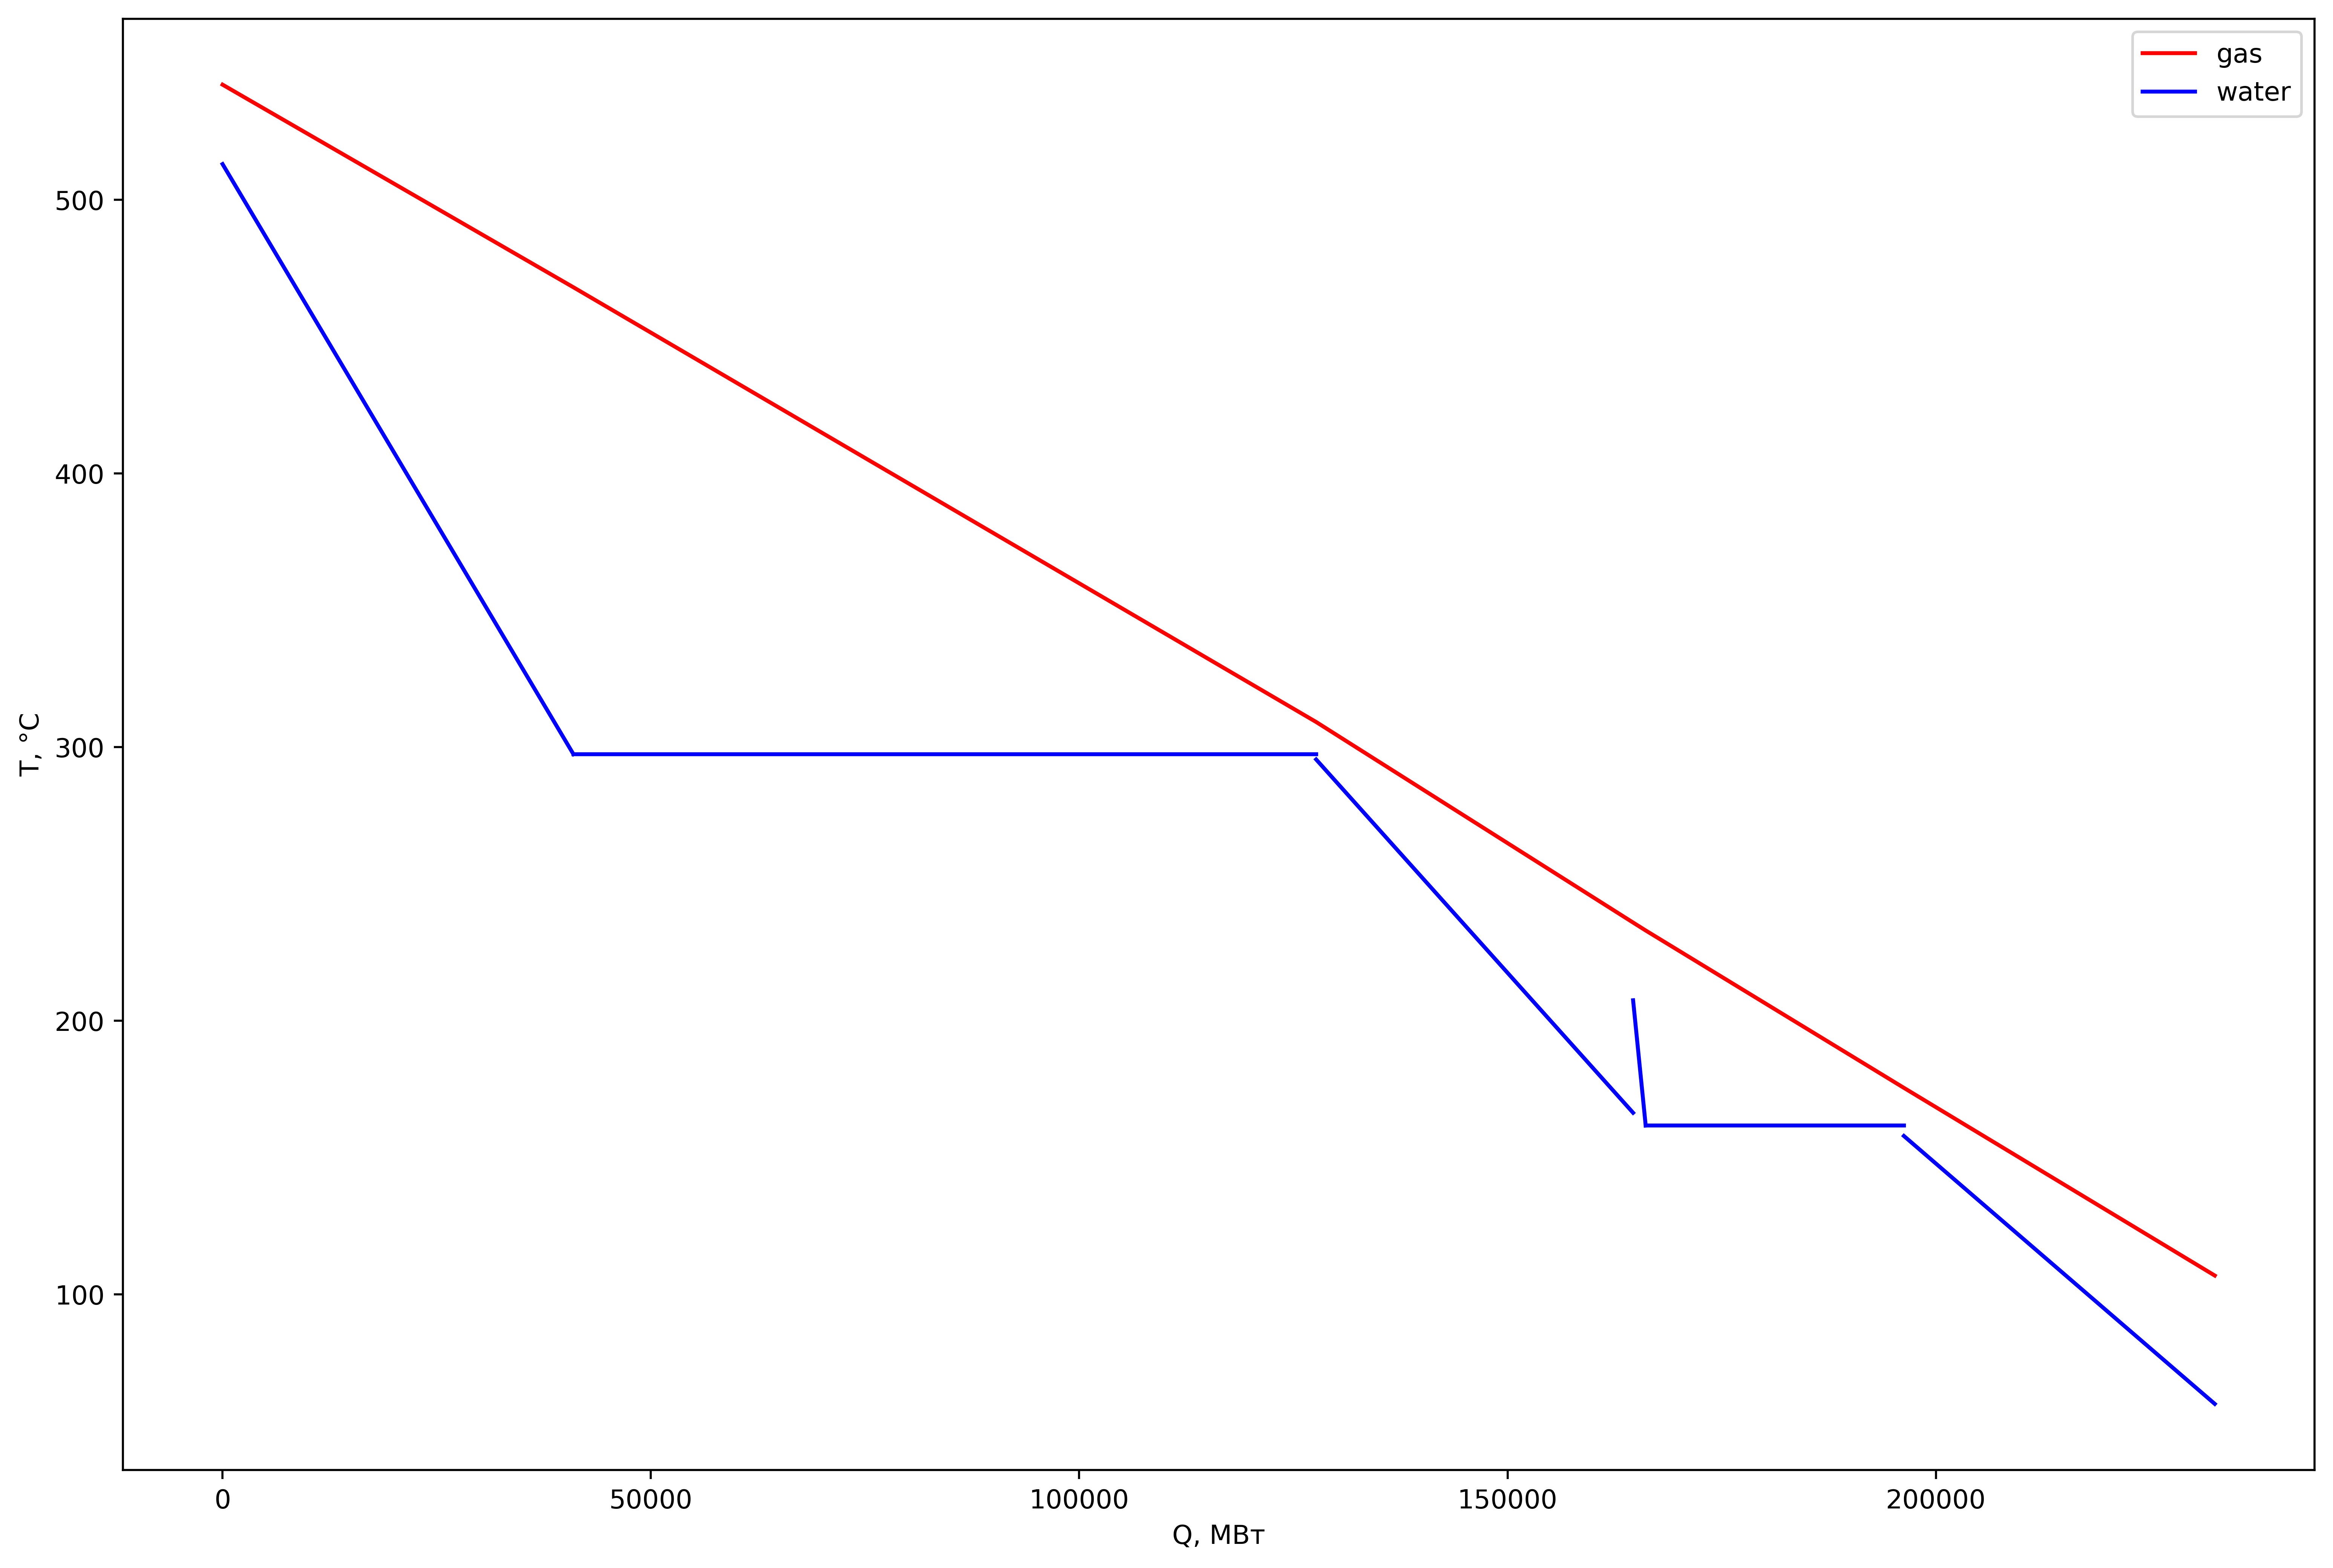

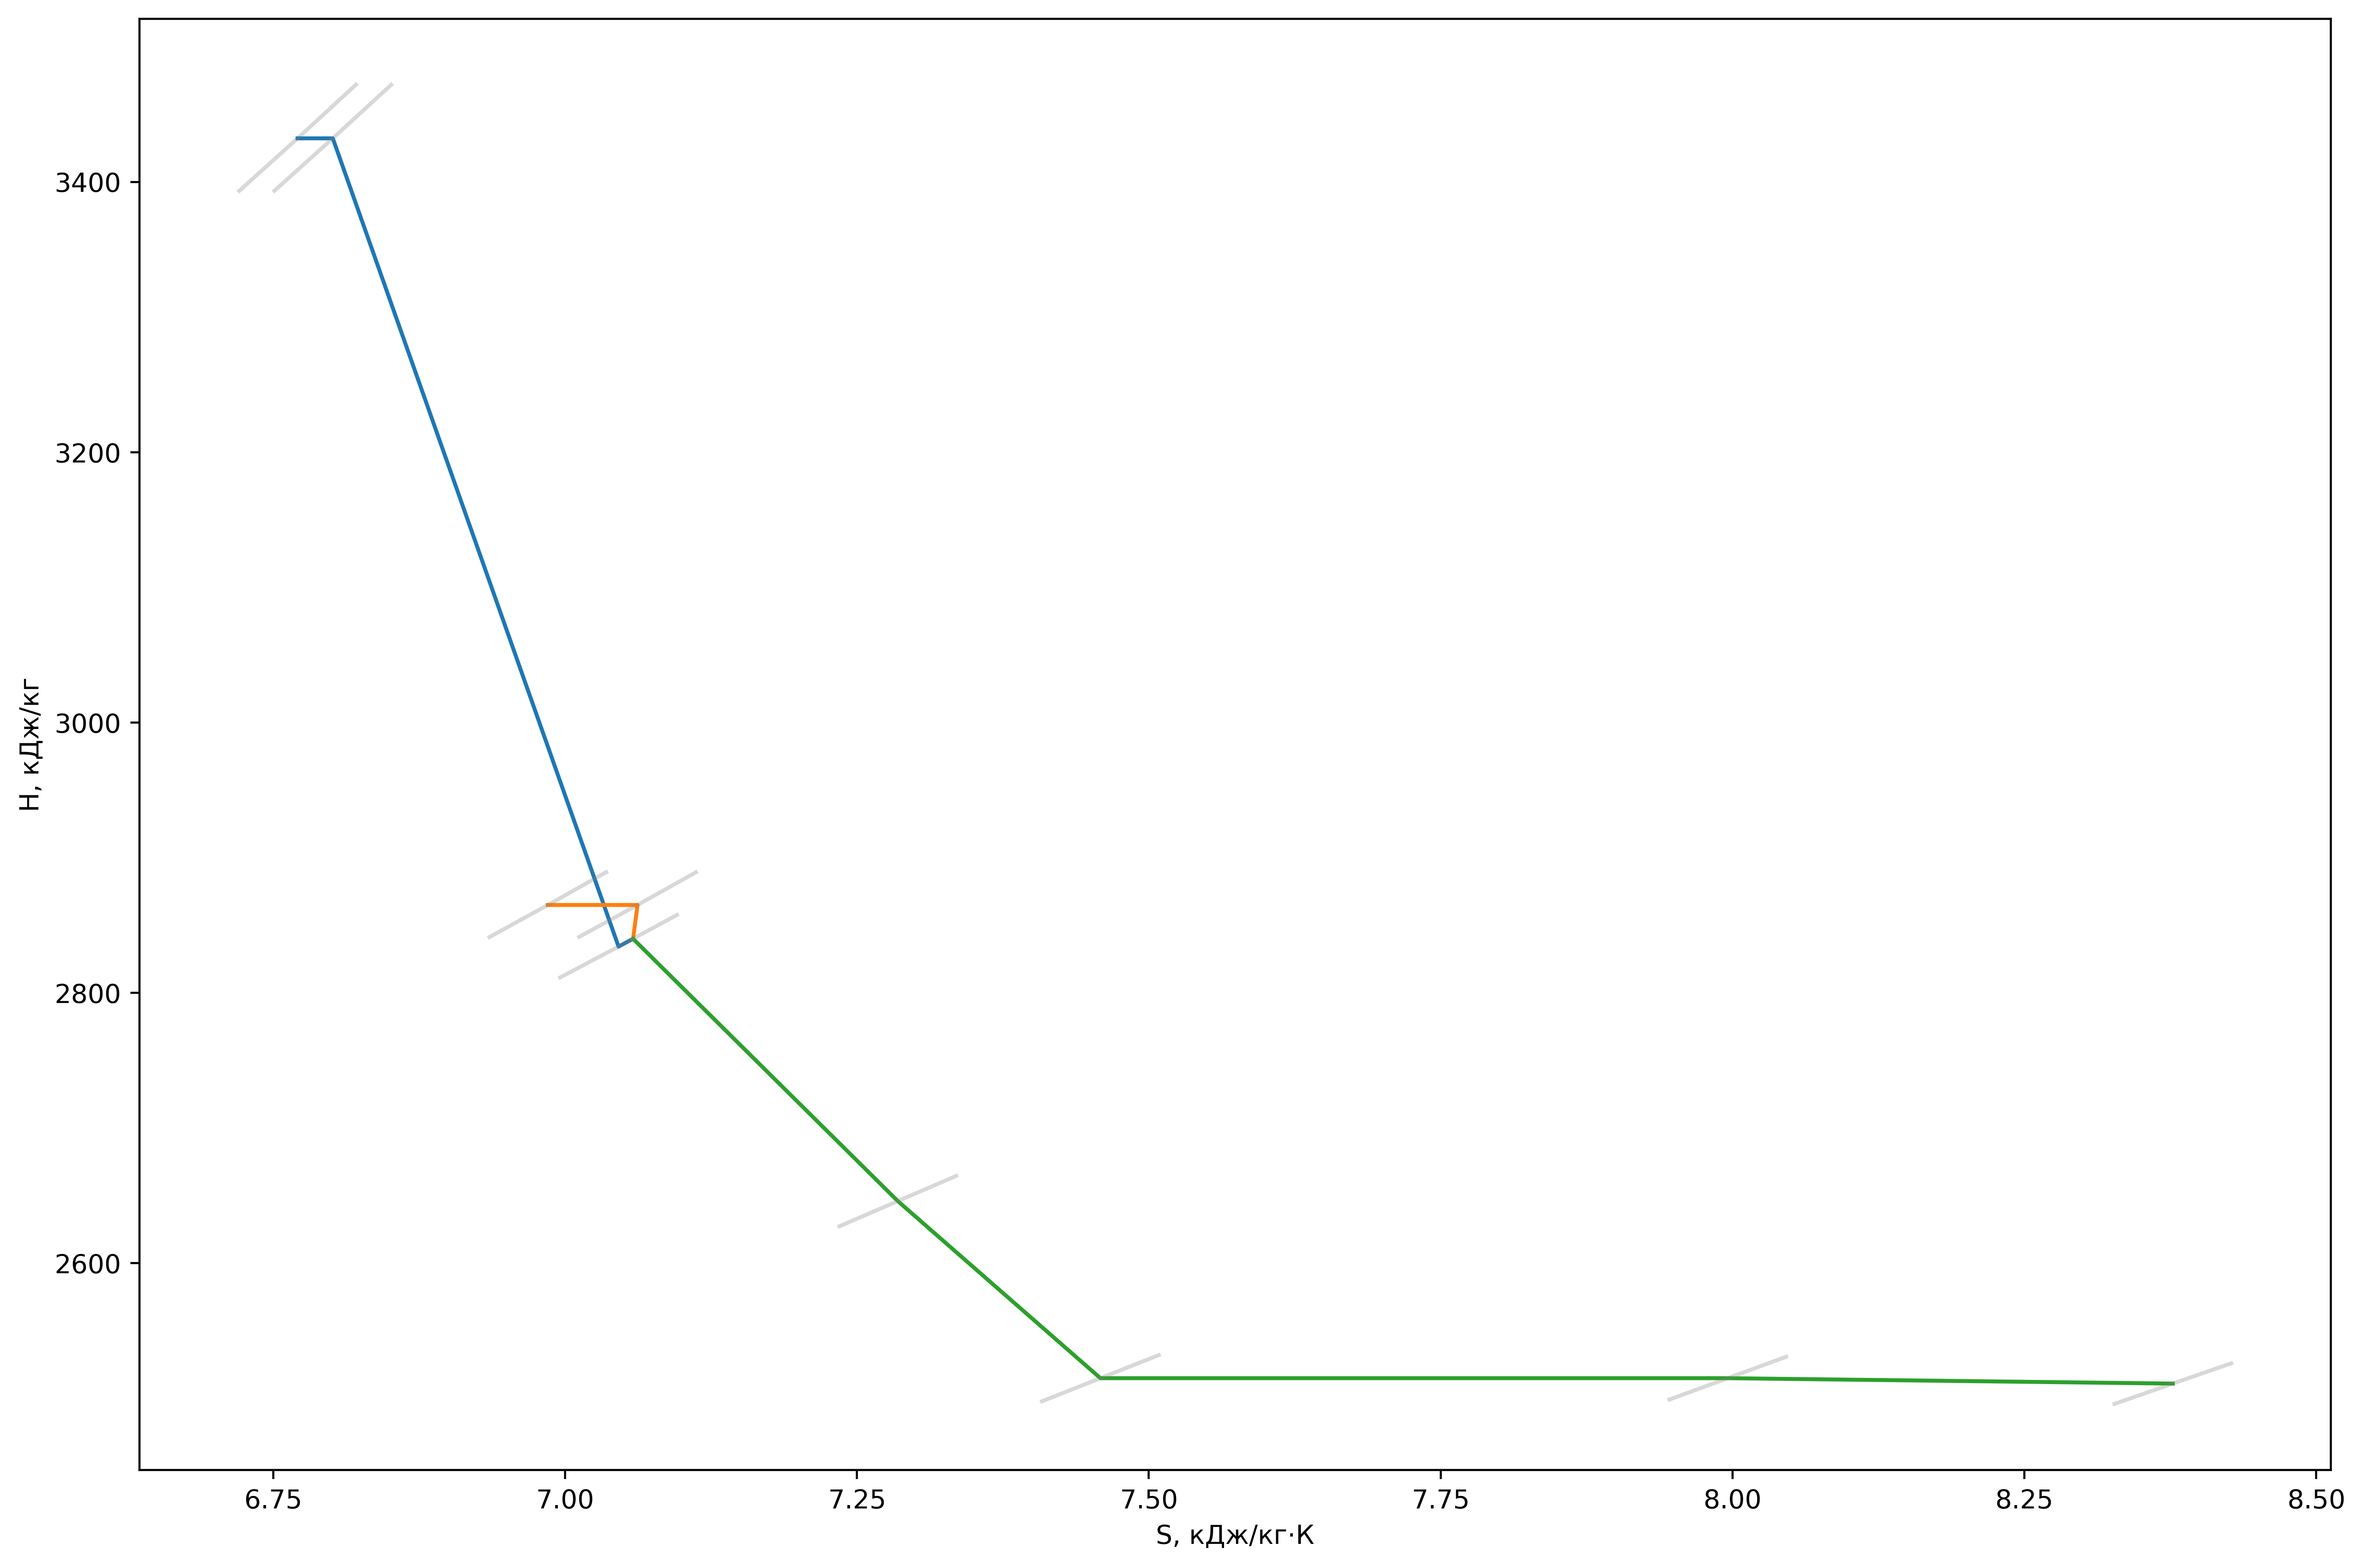

In [10]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)